Name -  Maitri Das

Roll no. - 19HS20028

In [ ]:
# standard libraries
import matplotlib
import numpy
import os
import sys
import glob
import pandas as pd
import random
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from sklearn.model_selection import train_test_split

# Pytorch Libraries
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensor
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchsummary import summary
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
transform = transforms.ToTensor()
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_dataset, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
data = mnist_dataset.__getitem__(4)

In [ ]:
data[0].shape

torch.Size([1, 28, 28])

## Parameters

In [ ]:
X_dim = 28*28
z_dim = 2

## Adversarial Autoencoder

In [ ]:
class encoder(nn.Module):
    def __init__(self, X_dim, z_dim):
        super(encoder, self).__init__()
        self.lin1 = nn.Linear(X_dim, 1000)
        self.lin2 = nn.Linear(1000, 1000)
        self.lin3gauss = nn.Linear(1000, z_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = F.relu(x)
        xgauss = self.lin3gauss(x)
        return xgauss

In [ ]:
# Decoder
class decoder(nn.Module):
    def __init__(self, z_dim, X_dim):
        super(decoder, self).__init__()
        self.lin1 = nn.Linear(z_dim, 1000)
        self.lin2 = nn.Linear(1000, 1000)
        self.lin3 = nn.Linear(1000, X_dim)
    def forward(self, x):
        x = self.lin1(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin3(x)
        return F.sigmoid(x)

In [ ]:
# Discriminator
class discriminator(nn.Module):
    def __init__(self, z_dim):
        super(discriminator, self).__init__()
        self.lin1 = nn.Linear(z_dim, 500)
        self.lin2 = nn.Linear(500, 1)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        return F.sigmoid(self.lin2(x))

## Hyperparameters 

In [ ]:
enc_lr = 0.0001
dis_lr = 0.00005
epochs = 100
batch_size = 64
EPS = 1e-15

## Utility Functions

In [ ]:
def to_np(x):
    return x.data.cpu().numpy()

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)    

## Training - Mean squared error loss

In [ ]:
torch.manual_seed(10)
enc, dec = encoder(X_dim, z_dim), decoder(z_dim, X_dim)
dis = discriminator(z_dim)

In [ ]:
#encode/decode optimizers
optim_dec = torch.optim.Adam(dec.parameters(), lr=enc_lr)
optim_enc = torch.optim.Adam(enc.parameters(), lr=enc_lr)
#regularizing optimizers
optim_enc_gen = torch.optim.Adam(enc.parameters(), lr=dis_lr)
optim_dis = torch.optim.Adam(dis.parameters(), lr=dis_lr)

In [ ]:
data_iter = iter(data_loader)
iter_per_epoch = len(data_loader)
total_step = epochs*iter_per_epoch

In [19]:
epoch = 1
loss_enc = {}
loss_dec = {}
loss_dis = {}
# Start training
for step in range(total_step):

    # Reset the data_iter
    if (step+1) % iter_per_epoch == 0:
        data_iter = iter(data_loader)

    # Fetch the images and labels and convert them to variables
    images, labels = next(data_iter)
    images, labels = to_var(images.view(images.size(0), -1)), to_var(labels)

    #reconstruction loss
    dec.zero_grad()
    enc.zero_grad()
    dis.zero_grad()

    z_sample = enc(images)   #encode to z
    X_sample = dec(z_sample) #decode to X reconstruction
    recon_loss = F.mse_loss(X_sample+EPS,images+EPS)
    loss_dec[epoch] = recon_loss

    recon_loss.backward()
    optim_dec.step()
    optim_enc.step()

    # Discriminator
    ## true prior is random normal (randn)
    ## this is constraining the Z-projection to be normal!
    enc.eval()
    z_real_gauss = Variable(torch.randn(images.size()[0], z_dim) * 5.)
    D_real_gauss = dis(z_real_gauss)

    z_fake_gauss = enc(images)
    D_fake_gauss = dis(z_fake_gauss)

    D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))
    loss_dis[epoch] = D_loss

    D_loss.backward()
    optim_dis.step()

    # Generator
    enc.train()
    z_fake_gauss = enc(images)
    D_fake_gauss = dis(z_fake_gauss)
    
    G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))
    loss_enc[epoch] = G_loss

    G_loss.backward()
    optim_enc_gen.step()   

    if (step+1) % iter_per_epoch == 0:
      print(f"Epoch: {epoch}/100")
      print(f"Loss encoder: {G_loss}", f"Loss decoder: {recon_loss}", f"Loss discriminator: {D_loss}")
      epoch = epoch + 1

#save the Encoder
torch.save(enc.state_dict(),'Q_encoder_weights.pt')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1/100
Loss encoder: 0.8843257427215576 Loss decoder: 0.05009131506085396 Loss discriminator: 0.7530828714370728
Epoch: 2/100
Loss encoder: 0.8549289703369141 Loss decoder: 0.051489442586898804 Loss discriminator: 0.7305314540863037
Epoch: 3/100
Loss encoder: 0.49947434663772583 Loss decoder: 0.054629165679216385 Loss discriminator: 0.6344159841537476
Epoch: 4/100
Loss encoder: 0.432508647441864 Loss decoder: 0.050304263830184937 Loss discriminator: 0.6680017113685608
Epoch: 5/100
Loss encoder: 0.32600095868110657 Loss decoder: 0.049600519239902496 Loss discriminator: 0.37367647886276245
Epoch: 6/100
Loss encoder: 0.33410465717315674 Loss decoder: 0.050797633826732635 Loss discriminator: 0.3896459937095642
Epoch: 7/100
Loss encoder: 0.36362138390541077 Loss decoder: 0.04733087494969368 Loss discriminator: 0.3626402020454407
Epoch: 8/100
Loss encoder: 0.4199414849281311 Loss decoder: 0.04771311581134796 Loss discriminator: 0.34198713302612305
Epoch: 9/100
Loss encoder: 0.370900213

## Plotting the reconstruction loss and discriminator loss

In [27]:
dec_val = [val.item() for val in loss_dec.values()]
dis_val = [val.item() for val in loss_dis.values()]

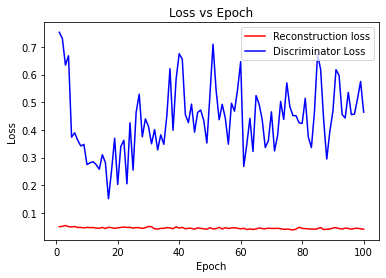

In [28]:
fig,ax = plt.subplots()
ax.plot(list(loss_dec.keys()),dec_val,c='r',label='Reconstruction loss')
ax.plot(list(loss_dis.keys()),dis_val,c='b',label='Discriminator Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Loss vs Epoch')
plt.show()

## Generating a Sample

In [35]:
enc_out = enc(mnist_dataset.__getitem__(0)[0].reshape(1, 784))
dec_out = dec(enc_out)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


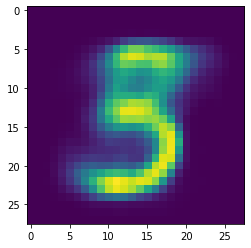

In [40]:
plt.imshow(dec_out.detach().numpy().reshape(28, 28))

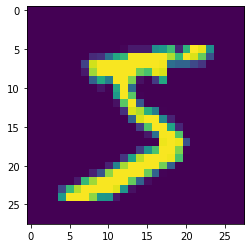

In [47]:
plt.imshow(mnist_dataset.__getitem__(0)[0].squeeze(0))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


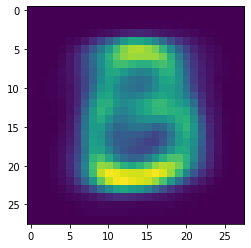

In [45]:
enc_out = enc(mnist_dataset.__getitem__(25)[0].reshape(1, 784))
dec_out = dec(enc_out)
plt.imshow(dec_out.detach().numpy().reshape(28, 28))

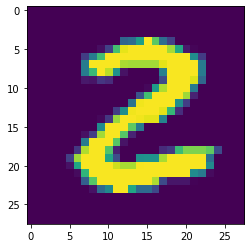

In [46]:
plt.imshow(mnist_dataset.__getitem__(25)[0].squeeze(0))

## Training - Binary Crossentropy loss

In [48]:
torch.manual_seed(10)
enc1, dec1 = encoder(X_dim, z_dim), decoder(z_dim, X_dim)
dis1 = discriminator(z_dim)

In [52]:
#encode/decode optimizers
optim_dec1 = torch.optim.Adam(dec1.parameters(), lr=enc_lr)
optim_enc1 = torch.optim.Adam(enc1.parameters(), lr=enc_lr)
#regularizing optimizers
optim_enc_gen1 = torch.optim.Adam(enc1.parameters(), lr=dis_lr)
optim_dis1 = torch.optim.Adam(dis1.parameters(), lr=dis_lr)

In [57]:
epochs = 30
data_iter1 = iter(data_loader)
iter_per_epoch1 = len(data_loader)
total_step = epochs*iter_per_epoch1

In [58]:
epoch = 1
loss_enc = {}
loss_dec = {}
loss_dis = {}
# Start training
for step in range(total_step):

    # Reset the data_iter
    if (step+1) % iter_per_epoch == 0:
        data_iter1 = iter(data_loader)

    # Fetch the images and labels and convert them to variables
    images, labels = next(data_iter1)
    images, labels = to_var(images.view(images.size(0), -1)), to_var(labels)

    #reconstruction loss
    dec1.zero_grad()
    enc1.zero_grad()
    dis1.zero_grad()

    z_sample = enc1(images)   #encode to z
    X_sample = dec1(z_sample) #decode to X reconstruction
    recon_loss = F.binary_cross_entropy(X_sample+EPS,images+EPS)
    loss_dec[epoch] = recon_loss

    recon_loss.backward()
    optim_dec1.step()
    optim_enc1.step()

    # Discriminator
    ## true prior is random normal (randn)
    ## this is constraining the Z-projection to be normal!
    enc1.eval()
    z_real_gauss = Variable(torch.randn(images.size()[0], z_dim) * 5.)
    D_real_gauss = dis1(z_real_gauss)

    z_fake_gauss = enc1(images)
    D_fake_gauss = dis1(z_fake_gauss)

    D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))
    loss_dis[epoch] = D_loss

    D_loss.backward()
    optim_dis1.step()

    # Generator
    enc1.train()
    z_fake_gauss = enc1(images)
    D_fake_gauss = dis1(z_fake_gauss)
    
    G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))
    loss_enc[epoch] = G_loss

    G_loss.backward()
    optim_enc_gen1.step()   

    if (step+1) % iter_per_epoch == 0:
      print(f"Epoch: {epoch}/{epochs}")
      print(f"Loss encoder: {G_loss}", f"Loss decoder: {recon_loss}", f"Loss discriminator: {D_loss}")
      epoch = epoch + 1

#save the Encoder
torch.save(enc1.state_dict(),'Q_encoder_weights.pt')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1/30
Loss encoder: 0.9804974794387817 Loss decoder: 0.20390400290489197 Loss discriminator: 0.9165140390396118
Epoch: 2/30
Loss encoder: 0.586223840713501 Loss decoder: 0.208461195230484 Loss discriminator: 0.7456680536270142
Epoch: 3/30
Loss encoder: 0.4155851900577545 Loss decoder: 0.19712041318416595 Loss discriminator: 0.5779280066490173
Epoch: 4/30
Loss encoder: 0.27706658840179443 Loss decoder: 0.21341243386268616 Loss discriminator: 0.5385174751281738
Epoch: 5/30
Loss encoder: 0.24473033845424652 Loss decoder: 0.21102726459503174 Loss discriminator: 0.3802146017551422
Epoch: 6/30
Loss encoder: 0.1972394734621048 Loss decoder: 0.1940861940383911 Loss discriminator: 0.5768821239471436
Epoch: 7/30
Loss encoder: 0.3278293013572693 Loss decoder: 0.19086533784866333 Loss discriminator: 0.45802128314971924
Epoch: 8/30
Loss encoder: 0.28878167271614075 Loss decoder: 0.20541007816791534 Loss discriminator: 0.3588758111000061
Epoch: 9/30
Loss encoder: 0.2529557943344116 Loss decode

## Plotting the reconstruction loss and discriminator loss

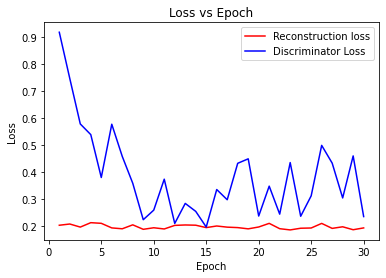

In [59]:
dec_val = [val.item() for val in loss_dec.values()]
dis_val = [val.item() for val in loss_dis.values()]
fig,ax = plt.subplots()
ax.plot(list(loss_dec.keys()),dec_val,c='r',label='Reconstruction loss')
ax.plot(list(loss_dis.keys()),dis_val,c='b',label='Discriminator Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Loss vs Epoch')
plt.show()

## Generating a Sample

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


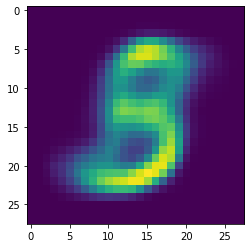

In [62]:
enc_out = enc1(mnist_dataset.__getitem__(0)[0].reshape(1, 784))
dec_out = dec1(enc_out)
plt.imshow(dec_out.detach().numpy().reshape(28, 28))

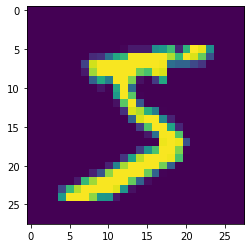

In [61]:
plt.imshow(mnist_dataset.__getitem__(0)[0].squeeze(0))

## Training process of Adversarial Auto encoders

The training procedure for this architecture for each minibatch is performed as follows:

1) A forward path through the encoder/decoder part is done, computing the reconstruction loss and updating the parameteres of the encoder and decoder networks.

2) I created a latent representation z = encoder(x) and take a sample z’ from the prior p(z), and trained each once through the discriminator and compute the score assigned to each (D(z) and D(z’)).

3) Next I computed the loss in the discriminator as and backpropagated it through the discriminator network to updated its weights.

4) Finally I computed the loss of the generator network and updated the encoder network accordingly.

## Thoughts on the loss functions

I trained the binary cross entropy for 30 epochs only but still it showed a better convergence then Mean squared error which I trined for 100 epochs

So, I think Binary cross entropy is better